In [30]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from google.colab import drive
import io

In [31]:
drive.mount('/content/drive/', force_remount=True)

# this is where I keep the experiment results on my google drive
# a zip of the folder can be found on github
# you may disable google drive, extract the zip and just point this path to that location
path = 'drive/MyDrive/inesc/potr'

Mounted at /content/drive/


In [32]:
def repeat_indices(reps):
  return reps.index.repeat(reps[0].values)

def potr(delay, rtt, n, hash_mean):
  return (delay - rtt[0] - n * hash_mean) / n

# Experiment 0: Find 50% Usage

In [33]:
sweep_usage = {
    "path": path + '/2024-06-11_16-29_sweep_usage_'
}

sweep_usage['readers'] = pd.read_table(sweep_usage['path'] + 'readers.txt', header=None)
sweep_usage['througput_near'] = pd.read_table(sweep_usage['path'] + 'near_throughput.txt', header=None) * 64000 / 1e6
sweep_usage['througput_sgx'] = pd.read_table(sweep_usage['path'] + 'sgx_throughput.txt', header=None) * 64000 / 1e6
sweep_usage['througput_tagus'] = pd.read_table(sweep_usage['path'] + 'tagus_throughput.txt', header=None) * 64000 / 1e6
sweep_usage['througput_netherlands'] = pd.read_table(sweep_usage['path'] + 'netherlands_throughput.txt', header=None) * 64000 / 1e6

sweep_usage['df'] = pd.concat([
    sweep_usage['readers'],
    sweep_usage['througput_near'] * 100 / sweep_usage['througput_near'].max()[0],
    sweep_usage['througput_sgx'] * 100 / sweep_usage['througput_sgx'].max()[0],
    sweep_usage['througput_tagus'] * 100 / sweep_usage['througput_tagus'].max()[0],
    sweep_usage['througput_netherlands'] * 100 / sweep_usage['througput_netherlands'].max()[0]], axis=1)
sweep_usage['df'].columns = ['readers', 'near', 'sgx', 'tagus', 'netherlands']
sweep_usage['df']

,readers,near,sgx,tagus,netherlands
0,0,0.000000,0.000000,0.000000,0.000000
1,2,2.287582,0.433532,2.397817,7.100491
2,4,8.655793,1.692442,8.238018,25.792239
3,6,18.335358,3.851765,17.120966,50.516862
4,8,30.860663,6.723915,28.233608,75.021183
5,10,44.528313,10.363083,41.184577,95.577021
6,12,57.221355,14.631706,53.807568,99.644128
7,14,71.256290,19.592313,67.549541,99.305203
8,16,84.860316,27.858602,81.112367,99.830537
9,18,96.677078,34.399100,92.393132,99.610236


<Axes: title={'center': 'Readers vs Usage'}, xlabel='Number of Load Generators', ylabel='Disk Usage (%)'>

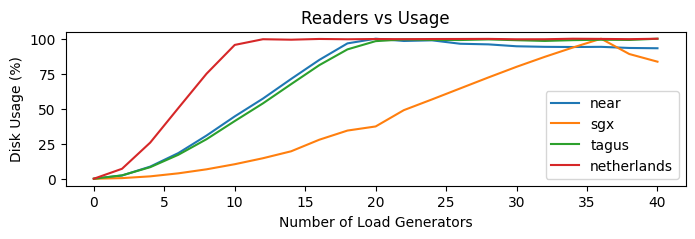

In [34]:
sweep_usage['df'].plot(
    x='readers',
    xlabel='Number of Load Generators',
    ylabel='Disk Usage (%)',
    title='Readers vs Usage',
    figsize=(8,2))

\begin{array}{ccc}
& \text{near} & \text{sgx}& \text{tagus} & \text{netherlands} \\
20\% & - & 14 & - & - \\
50\% & 11 & 22 & 11 & 6 \\
80\% & - & 30 & - & -
\end{array}

# Experiment 1: Time spent in enclave

In [35]:
enclave_time = {
    "path": path + '/2024-06-26_15-36_sweep_n_'
}

enclave_time['total'] = pd.read_table(enclave_time['path'] + 'real_delay.txt', header=None) / 1e6
enclave_time['enclave'] = pd.read_table(enclave_time['path'] + 'real_delay_enclave.txt', header=None) / 1e6
enclave_time['source'] = pd.read_table(enclave_time['path'] + 'remote_source.txt', header=None)
enclave_time['reps'] = pd.read_table(enclave_time['path'] + 'reps.txt', header=None)
enclave_time['n'] = pd.read_table(enclave_time['path'] + 'n.txt', header=None)

enclave_time['total'].index = repeat_indices(enclave_time['reps'] * enclave_time['n'])
enclave_time['enclave'].index = repeat_indices(enclave_time['reps'] * enclave_time['n'])

enclave_time['df'] = pd.concat([enclave_time['n'], enclave_time['total'], enclave_time['enclave']], axis=1)
enclave_time['df'].columns = ['n', 'total', 'enclave']
enclave_time['df'].set_index('n', append=True, inplace=True)

enclave_time['df2'] = enclave_time['df'].groupby(enclave_time['df'].index).sum()

enclave_time['df2'].index = pd.MultiIndex.from_tuples(enclave_time['df2'].index).droplevel()
enclave_time['df2'].set_index([enclave_time['source'].values[:,0], enclave_time['df2'].index], inplace=True)
enclave_time['df2'].index.names = ['Remote', 'N']
enclave_time['df2'].sort_index(inplace=True)

enclave_time['df2'] = enclave_time['df2'].loc[pd.IndexSlice[0, :], :]
enclave_time['df2'].index = enclave_time['df2'].index.droplevel()

enclave_time['df2']

,total,enclave
N,,
30,1.222378e+05,212.423981
50,2.016259e+05,413.636592
85,3.504152e+05,596.982998
100,4.096993e+05,711.292504
250,1.022786e+06,1927.414522
500,2.058782e+06,3568.273770


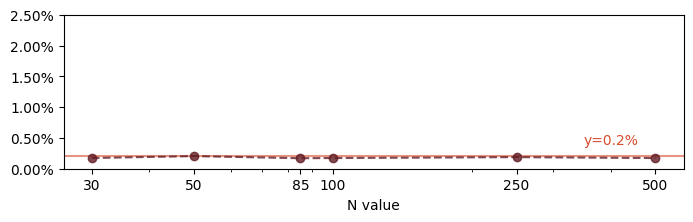

In [36]:
fig, ax = plt.subplots(figsize=(8,2))

ax.axhline(0.002, color='#d84b2d', alpha=0.6)
ax.text(x=350, y=0.004, s='y=0.2%', color='#d84b2d')

(enclave_time['df2'].enclave / enclave_time['df2'].total).plot(
    ax=ax,
    ylim=(0, 0.025),
    style='o--',
    color='#621d24',
    alpha=0.8
)

ax.set_xlabel('N value')
ax.set_xscale('log')
ax.set_xticks(enclave_time['df2'].index)
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))

In [37]:
enclave_time['df3'] = enclave_time['df'].groupby(enclave_time['df'].index).std()

enclave_time['df3'].index = pd.MultiIndex.from_tuples(enclave_time['df3'].index).droplevel()
enclave_time['df3'].set_index([enclave_time['source'].values[:,0], enclave_time['df3'].index], inplace=True)
enclave_time['df3'].index.names = ['Remote', 'N']
enclave_time['df3'].sort_index(inplace=True)

enclave_time['df3'] = enclave_time['df3'].loc[pd.IndexSlice[0, :], :]
enclave_time['df3'].index = enclave_time['df3'].index.droplevel()

enclave_time['df3']

,total,enclave
N,,
30,27.283751,0.046284
50,25.217511,0.052770
85,27.427836,0.045195
100,25.987036,0.046064
250,26.777741,0.052926
500,27.166376,0.055672


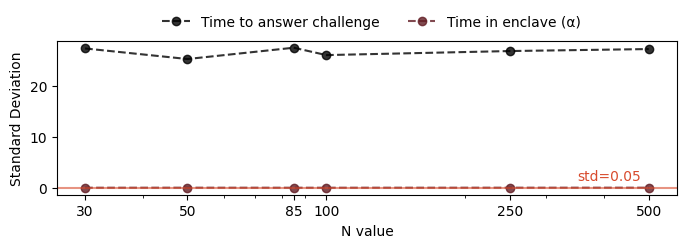

In [38]:
fig, ax = plt.subplots(figsize=(8,2))

enclave_time['df3'].plot(
    ax=ax,
    style='o--',
    color=['#000000', '#621d24'],
    alpha=0.8
)

ax.set_xlabel('N value')
ax.set_ylabel('Standard Deviation')
ax.set_xscale('log')
ax.set_xticks(enclave_time['df3'].index)
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.axhline(0.05, color='#d84b2d', alpha=0.6)
ax.text(x=350, y=1.5, s='std=0.05', color='#d84b2d')

ax.legend([
    'Time to answer challenge',
    'Time in enclave (α)'
], loc='upper left', bbox_to_anchor=(0.15, 1.25), ncol=2, frameon=False)

plt.savefig('alpha_std.pdf', dpi=300, bbox_inches = "tight")

# Experiment 2: PoATR FP/FN

In [39]:
poatr_fpfn = {
    "path": path + '/2024-06-26_15-36_sweep_n_'
}

poatr_fpfn['delay'] = pd.read_table(poatr_fpfn['path'] + 'delay.txt', header=None) / 1e6
poatr_fpfn['rtt'] = pd.read_table(poatr_fpfn['path'] + 'rtt.txt', header=None).mean() / 1e6
poatr_fpfn['source'] = pd.read_table(poatr_fpfn['path'] + 'remote_source.txt', header=None)
poatr_fpfn['reps'] = pd.read_table(poatr_fpfn['path'] + 'reps.txt', header=None)
poatr_fpfn['n'] = pd.read_table(poatr_fpfn['path'] + 'n.txt', header=None)

poatr_fpfn['delay'].index = repeat_indices(poatr_fpfn['reps'])
poatr_fpfn['potr'] = potr(
    poatr_fpfn['delay'],
    poatr_fpfn['rtt'],
    poatr_fpfn['n'].loc[repeat_indices(poatr_fpfn['reps'])],
    0.11)

poatr_fpfn['df'] = pd.concat([poatr_fpfn['n'], poatr_fpfn['potr']], axis=1)
poatr_fpfn['df'].columns = ['n', 'potr']
poatr_fpfn['df'].set_index('n', append=True, inplace=True)

cutoff = 45.2
poatr_fpfn['df']['detected'] = poatr_fpfn['df'].potr > cutoff

poatr_fpfn['df'] = poatr_fpfn['df'].groupby(poatr_fpfn['df'].index).agg({
    'potr': 'mean',
    'detected': 'sum'
})
poatr_fpfn['df'].detected /= poatr_fpfn['reps'].values[:,0]

poatr_fpfn['df'].index = pd.MultiIndex.from_tuples(poatr_fpfn['df'].index).droplevel()
poatr_fpfn['df'].set_index([poatr_fpfn['source'].values[:,0], poatr_fpfn['df'].index], inplace=True)
poatr_fpfn['df'].index.names = ['Remote', 'N']
poatr_fpfn['df'] = poatr_fpfn['df'].sort_index()

poatr_fpfn['df']['wrong'] = poatr_fpfn['df'].detected
poatr_fpfn['df'].wrong.loc[pd.IndexSlice[1, :]] = (1 - poatr_fpfn['df'].wrong.loc[pd.IndexSlice[1, :]]).values

poatr_fpfn['df']

potr  detected  wrong
Remote N                              
0      30   41.479963      0.20   0.20
       50   40.736227      0.14   0.14
       85   41.439336      0.11   0.11
       100  41.140783      0.09   0.09
       250  40.910359      0.03   0.03
       500  41.125764      0.04   0.04
1      30   46.759198      0.94   0.06
       50   46.570724      0.98   0.02
       85   46.442294      0.99   0.01
       100  46.266825      0.99   0.01
       250  46.128749      1.00   0.00
       500  46.093092      1.00   0.00

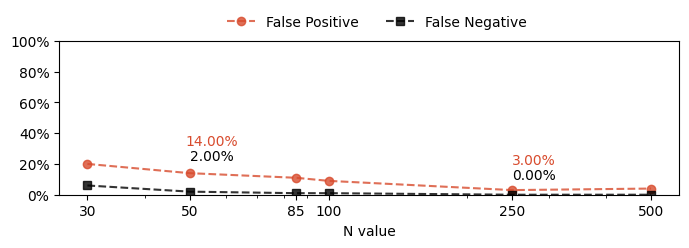

In [40]:
fig, ax = plt.subplots(figsize=(8,2))

poatr_fpfn['df'].wrong.unstack(level=0).plot(
    ax=ax,
    ylim=(0,1),
    color=['#d84b2d', '#000000'],
    style=['o--', 's--'],
    alpha=0.8
)

ax.legend([
    'False Positive',
    'False Negative'
], loc='upper left', bbox_to_anchor=(0.25, 1.25), ncol=2, frameon=False)

ax.text(x=49, y=0.325, s=f"{poatr_fpfn['df'].wrong.loc[pd.IndexSlice[0, 50]] * 100:.2f}%", color='#d84b2d')
ax.text(x=50, y=0.225, s=f"{poatr_fpfn['df'].wrong.loc[pd.IndexSlice[1, 50]] * 100:.2f}%", color='#000000')

ax.text(x=250, y=0.2, s=f"{poatr_fpfn['df'].wrong.loc[pd.IndexSlice[0, 250]] * 100:.2f}%", color='#d84b2d')
ax.text(x=250, y=0.1, s=f"{poatr_fpfn['df'].wrong.loc[pd.IndexSlice[1, 250]] * 100:.2f}%", color='#000000')

ax.set_xlabel('N value')
ax.set_xscale('log')
ax.set_xticks(poatr_fpfn['df'].index.levels[1])
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))

plt.savefig('poatr_performance.pdf', dpi=300, bbox_inches = "tight")

# Experiment 2.5: PoATR FP/FN - No Load

In [41]:
poatr_fpfn_no_load = {
    "path": path + '/2024-06-30_19-14_sweep_n_no_load_'
}

poatr_fpfn_no_load['delay'] = pd.read_table(poatr_fpfn_no_load['path'] + 'delay.txt', header=None) / 1e6
poatr_fpfn_no_load['rtt'] = pd.read_table(poatr_fpfn_no_load['path'] + 'rtt.txt', header=None).mean() / 1e6
poatr_fpfn_no_load['source'] = pd.read_table(poatr_fpfn_no_load['path'] + 'remote_source.txt', header=None)
poatr_fpfn_no_load['reps'] = pd.read_table(poatr_fpfn_no_load['path'] + 'reps.txt', header=None)
poatr_fpfn_no_load['n'] = pd.read_table(poatr_fpfn_no_load['path'] + 'n.txt', header=None)

poatr_fpfn_no_load['delay'].index = repeat_indices(poatr_fpfn_no_load['reps'])
poatr_fpfn_no_load['potr'] = potr(
    poatr_fpfn_no_load['delay'],
    poatr_fpfn_no_load['rtt'],
    poatr_fpfn_no_load['n'].loc[repeat_indices(poatr_fpfn_no_load['reps'])],
    0.11)

poatr_fpfn_no_load['df'] = pd.concat([poatr_fpfn_no_load['n'], poatr_fpfn_no_load['potr']], axis=1)
poatr_fpfn_no_load['df'].columns = ['n', 'potr']
poatr_fpfn_no_load['df'].set_index('n', append=True, inplace=True)

cutoff = 45.2
poatr_fpfn_no_load['df']['detected'] = poatr_fpfn_no_load['df'].potr > cutoff

poatr_fpfn_no_load['df'] = poatr_fpfn_no_load['df'].groupby(poatr_fpfn_no_load['df'].index).agg({
    'potr': 'mean',
    'detected': 'sum'
})
poatr_fpfn_no_load['df'].detected /= poatr_fpfn_no_load['reps'].values[:,0]

poatr_fpfn_no_load['df'].index = pd.MultiIndex.from_tuples(poatr_fpfn_no_load['df'].index).droplevel()
poatr_fpfn_no_load['df'].set_index([poatr_fpfn_no_load['source'].values[:,0], poatr_fpfn_no_load['df'].index], inplace=True)
poatr_fpfn_no_load['df'].index.names = ['Remote', 'N']
poatr_fpfn_no_load['df'] = poatr_fpfn_no_load['df'].sort_index()

poatr_fpfn_no_load['df']['wrong'] = poatr_fpfn_no_load['df'].detected
poatr_fpfn_no_load['df'].wrong.loc[pd.IndexSlice[1, :]] = (1 - poatr_fpfn_no_load['df'].wrong.loc[pd.IndexSlice[1, :]]).values

poatr_fpfn_no_load['df']

potr  detected  wrong
Remote N                              
0      30   18.908554       0.0    0.0
       50   18.868536       0.0    0.0
       85   18.377552       0.0    0.0
       100  18.139523       0.0    0.0
       250  18.141142       0.0    0.0
       500  18.042602       0.0    0.0
1      30   48.418437       1.0    0.0
       50   48.062279       1.0    0.0
       85   47.796712       1.0    0.0
       100  47.676323       1.0    0.0
       250  47.451954       1.0    0.0
       500  47.417035       1.0    0.0

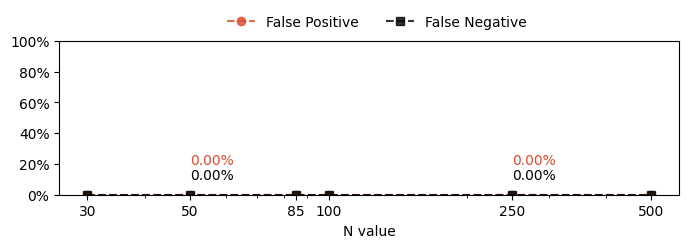

In [42]:
fig, ax = plt.subplots(figsize=(8,2))

poatr_fpfn_no_load['df'].wrong.unstack(level=0).plot(
    ax=ax,
    ylim=(0,1),
    color=['#d84b2d', '#000000'],
    style=['o--', 's--'],
    alpha=0.8
)

ax.legend([
    'False Positive',
    'False Negative'
], loc='upper left', bbox_to_anchor=(0.25, 1.25), ncol=2, frameon=False)

ax.text(x=50, y=0.2, s=f"{poatr_fpfn_no_load['df'].wrong.loc[pd.IndexSlice[0, 50]] * 100:.2f}%", color='#d84b2d')
ax.text(x=50, y=0.1, s=f"{poatr_fpfn_no_load['df'].wrong.loc[pd.IndexSlice[1, 50]] * 100:.2f}%", color='#000000')

ax.text(x=250, y=0.2, s=f"{poatr_fpfn_no_load['df'].wrong.loc[pd.IndexSlice[0, 250]] * 100:.2f}%", color='#d84b2d')
ax.text(x=250, y=0.1, s=f"{poatr_fpfn_no_load['df'].wrong.loc[pd.IndexSlice[1, 250]] * 100:.2f}%", color='#000000')

ax.set_xlabel('N value')
ax.set_xscale('log')
ax.set_xticks(poatr_fpfn_no_load['df'].index.levels[1])
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))

plt.savefig('poatr_performance_no_load.pdf', dpi=300, bbox_inches = "tight")

# Experiment 3: Remote Locations

In [43]:
remote_potr = {
    "path": path + '/2024-06-24_14-39_remote_potr_'
}

remote_potr['delay'] = pd.read_table(remote_potr['path'] + 'delay.txt', header=None) / 1e6
remote_potr['real'] = pd.read_table(remote_potr['path'] + 'real_delay.txt', header=None) / 1e6
remote_potr['rtt'] = pd.read_table(remote_potr['path'] + 'rtt.txt', header=None).mean() / 1e6
remote_potr['reps'] = pd.read_table(remote_potr['path'] + 'reps.txt', header=None)
remote_potr['n'] = pd.read_table(remote_potr['path'] + 'n.txt', header=None)

remote_potr['delay'].index = repeat_indices(remote_potr['reps'])
remote_potr['potr'] = potr(
    remote_potr['delay'],
    remote_potr['rtt'],
    remote_potr['n'].loc[repeat_indices(remote_potr['reps'])],
    0.11)

remote_potr['df'] = pd.DataFrame(remote_potr['potr'].values.reshape(len(remote_potr['reps']), -1)).transpose()
remote_potr['df'].columns = ['local', 'near', 'tagus', 'netherlands']

remote_potr['real'].index = repeat_indices(remote_potr['reps'] * remote_potr['n'])
remote_potr['reps2'] = remote_potr['reps'].loc[repeat_indices(remote_potr['n'])]
remote_potr['real_df'] = pd.DataFrame(remote_potr['real'].values.reshape(len(remote_potr['reps']), -1)).transpose()
remote_potr['real_df'].columns = ['local', 'near', 'tagus', 'netherlands']

remote_potr['real_df'].index //= 250
remote_potr['real_df'] = remote_potr['real_df'].groupby(remote_potr['real_df'].index).mean()

remote_potr['df']

,local,near,tagus,netherlands
0,43.510158,46.232893,51.319055,117.835218
1,42.213934,46.357990,51.761559,118.396231
2,42.097031,46.472425,51.960040,117.918939
3,41.931602,45.926933,51.705991,118.268597
4,39.875610,45.755260,51.482282,118.155092
...,...,...,...,...
95,45.102580,46.333074,51.349363,118.169387
96,41.209935,45.947668,51.874073,117.753988
97,41.405387,46.315558,51.626047,118.111171
98,38.397510,45.916335,51.233771,117.736491


In [44]:
remote_potr['real_df']

,local,near,tagus,netherlands
0,43.305685,46.186292,51.274734,117.647665
1,42.313134,46.314159,51.717778,118.351606
2,42.052783,46.427390,51.916587,117.873968
3,41.889734,45.885852,51.662652,118.219851
4,39.827740,45.711551,51.580275,118.110650
...,...,...,...,...
95,45.063394,46.289399,51.307066,118.125445
96,41.167896,46.046819,51.830374,117.703894
97,41.363619,46.268728,51.581265,118.068001
98,38.352583,46.016499,51.329955,117.692594


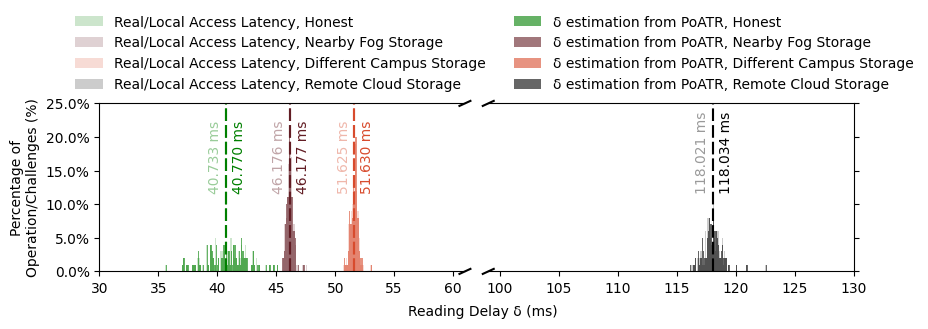

In [45]:
colors = ['#008000', '#621d24', '#d84b2d', '#000000']
labels = [
    'Real/Local Access Latency, Honest',
    'Real/Local Access Latency, Nearby Fog Storage',
    'Real/Local Access Latency, Different Campus Storage',
    'Real/Local Access Latency, Remote Cloud Storage',
    'δ estimation from PoATR, Honest',
    'δ estimation from PoATR, Nearby Fog Storage',
    'δ estimation from PoATR, Different Campus Storage',
    'δ estimation from PoATR, Remote Cloud Storage',
]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,2))
fig.tight_layout(pad=0.1)

remote_potr['real_df'].plot.hist(
    ax=ax1,
    weights=np.ones(len(remote_potr['real_df'])) / len(remote_potr['real_df']),
    color=colors,
    alpha=0.2,
    bins=800)

remote_potr['real_df'].plot.hist(
    ax=ax2,
    weights=np.ones(len(remote_potr['real_df'])) / len(remote_potr['real_df']),
    color=colors,
    alpha=0.2,
    bins=800)

remote_potr['df'].plot.hist(
    ax=ax1,
    weights=np.ones(len(remote_potr['df'])) / len(remote_potr['df']),
    color=colors,
    alpha=0.6,
    bins=800)

remote_potr['df'].plot.hist(
    ax=ax2,
    weights=np.ones(len(remote_potr['df'])) / len(remote_potr['df']),
    color=colors,
    alpha=0.6,
    bins=800)

for (i, mean) in enumerate(remote_potr['df'].mean()):
  if (i < 3):
    ax1.axvline(x=mean, c=colors[i], dashes = [6,2])
    ax1.text(mean + 0.5, 0.12, f"{mean:.3f} ms", rotation='vertical', color=colors[i])
  else:
    ax2.axvline(x=mean, c=colors[i], dashes = [6,2])
    ax2.text(mean + 0.5, 0.12, f"{mean:.3f} ms", rotation='vertical', color=colors[i])

for (i, mean) in enumerate(remote_potr['real_df'].mean()):
  if (i < 3):
    ax1.axvline(x=mean, c=colors[i], dashes = [6,2])
    ax1.text(mean - 1.5, 0.12, f"{mean:.3f} ms", rotation='vertical', color=colors[i], alpha=0.4)
  else:
    ax2.axvline(x=mean, c=colors[i], dashes = [6,2], alpha=0.4)
    ax2.text(mean - 1.5, 0.12, f"{mean:.3f} ms", rotation='vertical', color=colors[i], alpha=0.4)

ax1.set_xlim(30, 61)
ax2.set_xlim(99, 130)
ax1.set_ylim(0, 0.25)
ax2.set_ylim(0, 0.25)

ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()

ax1.legend(labels, loc='upper left', bbox_to_anchor=(-0.1, 1.6), ncol=2, frameon=False)
ax2.legend().remove()

ax1.set_ylabel('Percentage of\nOperation/Challenges (%)')
ax1.set_xlabel('Reading Delay δ (ms)')
ax1.xaxis.set_label_coords(1.05, -0.2)
ax1.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))

d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

plt.savefig('250N_64000B_LatencyDiagram.pdf', dpi=300, bbox_inches = "tight")
plt.show()

# Experiment 3.5: Remote Locations - No Load

In [46]:
remote_potr_no_load = {
    "path": path + '/2024-06-27_15-33_remote_potr_no_load_'
}

remote_potr_no_load['delay'] = pd.read_table(remote_potr_no_load['path'] + 'delay.txt', header=None) / 1e6
remote_potr_no_load['real'] = pd.read_table(remote_potr_no_load['path'] + 'real_delay.txt', header=None) / 1e6
remote_potr_no_load['rtt'] = pd.read_table(remote_potr_no_load['path'] + 'rtt.txt', header=None).mean() / 1e6
remote_potr_no_load['reps'] = pd.read_table(remote_potr_no_load['path'] + 'reps.txt', header=None)
remote_potr_no_load['n'] = pd.read_table(remote_potr_no_load['path'] + 'n.txt', header=None)

remote_potr_no_load['delay'].index = repeat_indices(remote_potr_no_load['reps'])
remote_potr_no_load['n2'] = remote_potr_no_load['n'].loc[repeat_indices(remote_potr_no_load['reps'])]
remote_potr_no_load['potr'] = potr(remote_potr_no_load['delay'], remote_potr_no_load['rtt'], remote_potr_no_load['n2'], 0.11)

remote_potr_no_load['df'] = pd.DataFrame(remote_potr_no_load['potr'].values.reshape(len(remote_potr_no_load['reps']), -1)).transpose()
remote_potr_no_load['df'].columns = ['local', 'near', 'tagus', 'netherlands']

remote_potr_no_load['real'].index = repeat_indices(remote_potr_no_load['reps'] * remote_potr_no_load['n'])
remote_potr_no_load['reps2'] = remote_potr_no_load['reps'].loc[repeat_indices(remote_potr_no_load['n'])]
remote_potr_no_load['real_df'] = pd.DataFrame(remote_potr_no_load['real'].values.reshape(len(remote_potr_no_load['reps']), -1)).transpose()
remote_potr_no_load['real_df'].columns = ['local', 'near', 'tagus', 'netherlands']

remote_potr_no_load['real_df'].index //= 250
remote_potr_no_load['real_df'] = remote_potr_no_load['real_df'].groupby(remote_potr_no_load['real_df'].index).mean()

remote_potr_no_load['df']

,local,near,tagus,netherlands
0,18.021625,47.415277,51.597002,121.291321
1,19.486603,47.421183,51.533739,119.482992
2,18.399805,47.581024,51.625257,119.043938
3,18.155009,46.618446,51.640509,119.373946
4,19.226800,46.907338,51.082764,121.631533
...,...,...,...,...
95,20.470773,47.643937,51.467351,119.454131
96,17.177468,47.678340,51.677412,118.024329
97,18.490886,47.655612,51.261425,122.171803
98,16.978456,47.277624,51.140662,118.623763


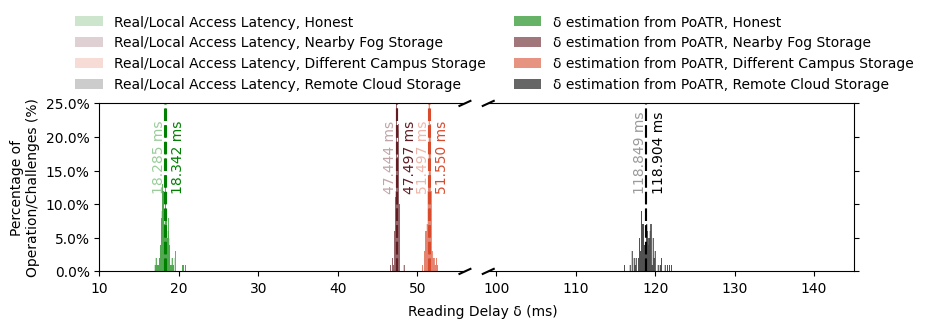

In [47]:
colors = ['#008000', '#621d24', '#d84b2d', '#000000']
labels = [
    'Real/Local Access Latency, Honest',
    'Real/Local Access Latency, Nearby Fog Storage',
    'Real/Local Access Latency, Different Campus Storage',
    'Real/Local Access Latency, Remote Cloud Storage',
    'δ estimation from PoATR, Honest',
    'δ estimation from PoATR, Nearby Fog Storage',
    'δ estimation from PoATR, Different Campus Storage',
    'δ estimation from PoATR, Remote Cloud Storage',
]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,2))
fig.tight_layout(pad=0.1)

remote_potr_no_load['real_df'].plot.hist(
    ax=ax1,
    weights=np.ones(len(remote_potr_no_load['real_df'])) / len(remote_potr_no_load['real_df']),
    color=colors,
    alpha=0.2,
    bins=800)

remote_potr_no_load['real_df'].plot.hist(
    ax=ax2,
    weights=np.ones(len(remote_potr_no_load['real_df'])) / len(remote_potr_no_load['real_df']),
    color=colors,
    alpha=0.2,
    bins=800)

remote_potr_no_load['df'].plot.hist(
    ax=ax1,
    weights=np.ones(len(remote_potr_no_load['df'])) / len(remote_potr_no_load['df']),
    color=colors,
    alpha=0.6,
    bins=800)

remote_potr_no_load['df'].plot.hist(
    ax=ax2,
    weights=np.ones(len(remote_potr_no_load['df'])) / len(remote_potr_no_load['df']),
    color=colors,
    alpha=0.6,
    bins=800)

for (i, mean) in enumerate(remote_potr_no_load['df'].mean()):
  if (i < 3):
    ax1.axvline(x=mean, c=colors[i], dashes = [6,2])
    ax1.text(mean + 0.7, 0.12, f"{mean:.3f} ms", rotation='vertical', color=colors[i])
  else:
    ax2.axvline(x=mean, c=colors[i], dashes = [6,2])
    ax2.text(mean + 0.7, 0.12, f"{mean:.3f} ms", rotation='vertical', color=colors[i])

for (i, mean) in enumerate(remote_potr_no_load['real_df'].mean()):
  if (i < 3):
    ax1.axvline(x=mean, c=colors[i], dashes = [6,2])
    ax1.text(mean - 1.7, 0.12, f"{mean:.3f} ms", rotation='vertical', color=colors[i], alpha=0.4)
  else:
    ax2.axvline(x=mean, c=colors[i], dashes = [6,2], alpha=0.4)
    ax2.text(mean - 1.7, 0.12, f"{mean:.3f} ms", rotation='vertical', color=colors[i], alpha=0.4)

ax1.set_xlim(10, 56)
ax2.set_xlim(99, 145)
ax1.set_ylim(0, 0.25)
ax2.set_ylim(0, 0.25)

ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()

ax1.legend(labels, loc='upper left', bbox_to_anchor=(-0.1, 1.6), ncol=2, frameon=False)
ax2.legend().remove()

ax1.set_ylabel('Percentage of\nOperation/Challenges (%)')
ax1.set_xlabel('Reading Delay δ (ms)')
ax1.xaxis.set_label_coords(1.05, -0.2)
ax1.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))

d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

plt.savefig('250N_64000B_LatencyDiagram_no_load.pdf', dpi=300, bbox_inches = "tight")
plt.show()

# Experiment 4: Mixed Storage

In [48]:
mixed = {
    "path": path + '/2024-06-24_12-43_mixed_'
}

mixed['delay'] = pd.read_table(mixed['path'] + 'delay.txt', header=None) / 1e6
mixed['rtt'] = pd.read_table(mixed['path'] + 'rtt.txt', header=None).mean() / 1e6
mixed['reps'] = pd.read_table(mixed['path'] + 'reps.txt', header=None)
mixed['n'] = pd.read_table(mixed['path'] + 'n.txt', header=None)

mixed['delay'].index = repeat_indices(mixed['reps'])
mixed['n'] = mixed['n'].loc[repeat_indices(mixed['reps'])]
mixed['potr'] = potr(mixed['delay'], mixed['rtt'], mixed['n'], 0.11)

mixed['df'] = pd.DataFrame(mixed['potr'].values.reshape(len(mixed['reps']), -1)).transpose()
mixed['df'].columns = ['local', 'tagus', 'netherlands 10%', 'netherlands 25%']

mixed['stats'] = pd.concat([mixed['df'].mean(), mixed['df'].std()], axis=1)
mixed['stats'].columns = ['mean', 'std']

mixed['df']

,local,tagus,netherlands 10%,netherlands 25%
0,43.107160,51.006021,44.866569,57.632341
1,41.656557,51.503569,50.516068,61.048400
2,43.078233,52.371016,45.517767,57.380675
3,43.162472,50.780177,47.435330,57.553121
4,41.873866,50.948216,50.185602,59.066919
...,...,...,...,...
95,41.856807,51.111630,47.471547,57.125746
96,42.535057,51.411851,47.871290,60.885444
97,41.174651,51.728504,45.521701,57.845126
98,42.161135,51.477579,47.421080,54.248709


In [49]:
local_cutoff = mixed['df']['local'].max()

print(f"10% - {local_cutoff:.2f}ms")
print((mixed['df']['netherlands 10%'] > local_cutoff).sum() / len(mixed['df']))
print(f"25% - {local_cutoff:.2f}ms")
print((mixed['df']['netherlands 25%'] > local_cutoff).sum() / len(mixed['df']))

10% - 44.76ms
0.9
25% - 44.76ms
1.0


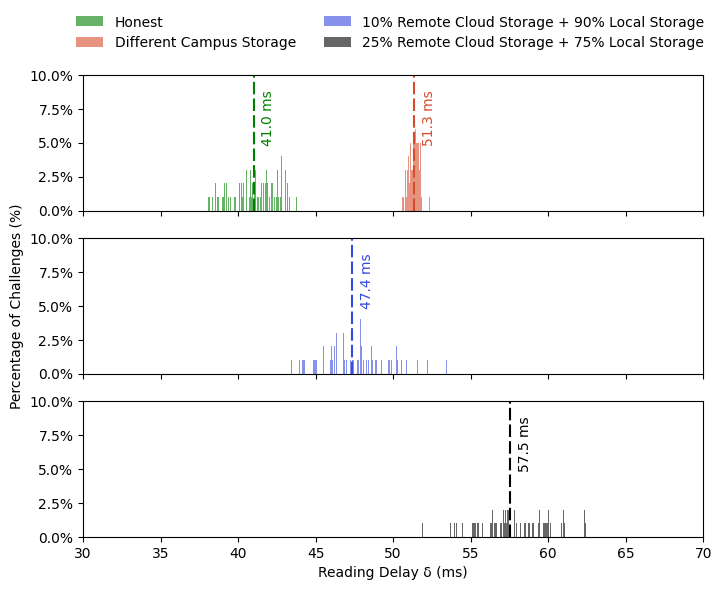

In [50]:
colors = ['#008000', '#d84b2d', '#354adf', '#000000']
labels = [
    'Honest',
    'Different Campus Storage',
    '10% Remote Cloud Storage + 90% Local Storage',
    '25% Remote Cloud Storage + 75% Local Storage'
]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8,6))

mixed['df'].iloc[:,0:2].plot.hist(
    ax=ax1,
    weights=np.ones(len(mixed['df'])) / len(mixed['df']),
    color=colors[0:2],
    alpha=0.6,
    bins=300)

mixed['df'].iloc[:,2].plot.hist(
    ax=ax2,
    weights=np.ones(len(mixed['df'])) / len(mixed['df']),
    color=colors[2],
    alpha=0.6,
    bins=300)

mixed['df'].iloc[:,3].plot.hist(
    ax=ax3,
    weights=np.ones(len(mixed['df'])) / len(mixed['df']),
    color=colors[3],
    alpha=0.6,
    bins=300)

for (i, mean) in enumerate(mixed['df'].mean()):
  if (i < 2):
    ax1.axvline(x=mean, c=colors[i], dashes = [6,2])
    ax1.text(mean + 0.5, 0.05, f"{mean:.1f} ms", rotation='vertical', color=colors[i])
  elif (i == 2):
    ax2.axvline(x=mean, c=colors[i], dashes = [6,2])
    ax2.text(mean + 0.5, 0.05, f"{mean:.1f} ms", rotation='vertical', color=colors[i])
  else:
    ax3.axvline(x=mean, c=colors[i], dashes = [6,2])
    ax3.text(mean + 0.5, 0.05, f"{mean:.1f} ms", rotation='vertical', color=colors[i])


l = []
for ax in fig.axes:
    lines, label = ax.get_legend_handles_labels()
    l.extend(lines)
fig.legend(l, labels, loc='upper left', bbox_to_anchor=(0.1, 1), ncol=2, frameon=False)

ax1.legend().remove()

ax1.set_ylim(0, 0.1)
ax2.set_ylim(0, 0.1)
ax3.set_ylim(0, 0.1)
ax3.set_xlim(30, 70)

ax1.set_ylabel(None)
ax2.set_ylabel('Percentage of Challenges (%)')
ax3.set_ylabel(None)
ax3.set_xlabel('Reading Delay δ (ms)')
ax1.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
ax2.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
ax3.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))

plt.savefig('mixedlatency250.pdf', dpi=300, bbox_inches = "tight")
plt.show()

# Experiment 5: Mixed Standard Deviation

In [51]:
mixed_multiple_n = {
    "path": path + '/2024-06-25_00-23_mixed_multiple_n_'
}

mixed_multiple_n['delay'] = pd.read_table(mixed_multiple_n['path'] + 'delay.txt', header=None) / 1e6
mixed_multiple_n['rtt'] = pd.read_table(mixed_multiple_n['path'] + 'rtt.txt', header=None).mean() / 1e6
mixed_multiple_n['reps'] = pd.read_table(mixed_multiple_n['path'] + 'reps.txt', header=None)
mixed_multiple_n['n'] = pd.read_table(mixed_multiple_n['path'] + 'n.txt', header=None)
mixed_multiple_n['remote'] = pd.read_table(mixed_multiple_n['path'] + 'remote.txt', header=None)

mixed_multiple_n['delay'].index = repeat_indices(mixed_multiple_n['reps'])
mixed_multiple_n['n2'] = mixed_multiple_n['n'].loc[repeat_indices(mixed_multiple_n['reps'])]
mixed_multiple_n['potr'] = potr(mixed_multiple_n['delay'], mixed_multiple_n['rtt'], mixed_multiple_n['n2'], 0.11)

mixed_multiple_n['df'] = pd.concat([
    mixed_multiple_n['n'],
    mixed_multiple_n['remote'],
    mixed_multiple_n['potr'].groupby(mixed_multiple_n['potr'].index).mean(),
    mixed_multiple_n['potr'].groupby(mixed_multiple_n['potr'].index).std()], axis=1)
mixed_multiple_n['df'].columns = ['N', 'remote (%)', 'mean', 'std']

mixed_multiple_n['potr']

,0
0,82.190863
0,42.543487
0,32.467083
0,29.920186
0,41.235088
...,...
29,120.227889
29,119.610829
29,118.758227
29,119.691440


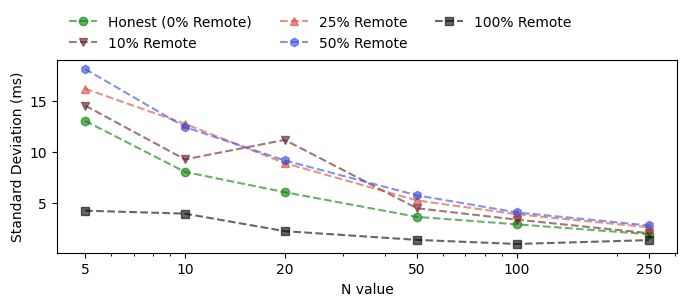

In [52]:
colors = ['#008000', '#621d24', '#d84b2d', '#354adf', '#000000']
shapes = ['o--', 'v--', '^--', 'h--', 's--']
remote = ['0%', '10%', '25%', '50%', '100%']
labels = ['Honest (0% Remote)', '10% Remote', '25% Remote', '50% Remote', '100% Remote']

plt.figure(figsize=(8,2.5))

df_pivot = mixed_multiple_n['df'].pivot(index='N', columns='remote (%)', values='std')
df_pivot.columns = [f'{col}%' for col in df_pivot.columns]
df_pivot.reset_index(inplace=True)

for (i,r) in enumerate(remote):
    plt.plot('N', r, shapes[i], color=colors[i], alpha=0.6, data=df_pivot)
ax = plt.gca()
ax.set_xscale('log')
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(df_pivot['N'])

ax.legend(labels, loc='upper left', bbox_to_anchor=(0, 1.3), ncol=3, frameon=False)

ax.set_ylabel('Standard Deviation (ms)')
ax.set_xlabel('N value')

plt.savefig('variances.pdf', dpi=300, bbox_inches = "tight")
plt.show()

# Experiment 6: PoUTR FP/FN

In [53]:
poutr_accuracy = {
    "path": path + '/2024-06-29_19-34_poutr_accuracy_v2_'
}

poutr_accuracy['delay'] = pd.read_table(poutr_accuracy['path'] + 'delay.txt', header=None) / 1e6
poutr_accuracy['rtt'] = pd.read_table(poutr_accuracy['path'] + 'rtt.txt', header=None).mean() / 1e6
poutr_accuracy['remote'] = pd.read_table(poutr_accuracy['path'] + 'remote.txt', header=None)
poutr_accuracy['reps'] = pd.read_table(poutr_accuracy['path'] + 'reps.txt', header=None)
poutr_accuracy['n'] = pd.read_table(poutr_accuracy['path'] + 'n.txt', header=None)

poutr_accuracy['remote'].replace({0: False, 10: True}, inplace=True)
poutr_accuracy['df'] = pd.concat([poutr_accuracy['remote'], poutr_accuracy['n']], axis = 1)
poutr_accuracy['df'].columns = ['remote', 'N']
poutr_accuracy['df'] = poutr_accuracy['df'].loc[repeat_indices(poutr_accuracy['reps']), :].reset_index(drop=True)
poutr_accuracy['df']['delay'] = poutr_accuracy['delay']

poutr_accuracy['df']['potr'] = potr(poutr_accuracy['df'].delay, poutr_accuracy['rtt'], poutr_accuracy['df'].N, 0.11)
poutr_accuracy['df'].set_index(['remote', 'N'], inplace=True)
poutr_accuracy['df'].drop('delay', axis=1, inplace=True)
poutr_accuracy['df'].sort_index(inplace=True)

for k in range(5, 41, 5):
  poutr_accuracy['df'][("k", k)] = poutr_accuracy['df'].groupby(poutr_accuracy['df'].index).cumcount() // k

def get_poatr(x):
  poatrs = tmp.loc[pd.IndexSlice[x.index.droplevel([1,2])[0], 250, :], :].potr.values
  i = x.index.droplevel([0,1])[0]
  if i >= len(poatrs):
    return np.nan
  else:
    return poatrs[i]

def std_poatr(x):
  poatr = get_poatr(x)
  if poatr == np.nan:
    return np.nan
  else:
    return np.sqrt(np.square(x - poatr).sum() / (x.count() - 1))

dfs = []
for k in range(5, 41, 5):
  tmp = poutr_accuracy['df'][['potr', ("k", k)]]
  tmp.set_index([("k", k)], append=True, inplace=True)

  tmp = tmp.groupby(tmp.index).agg([
      get_poatr, # result of corresponding poatr
      "std",
      std_poatr
  ])

  tmp.rename(columns={"potr": k}, inplace=True)
  tmp.columns = tmp.columns.set_levels(['poatr', 'std', 'std_poatr'], level=1)
  tmp.reset_index(inplace=True, names=["level_0", "level_1"])
  tmp.index = pd.MultiIndex.from_tuples(tmp.level_0)
  tmp.index.names = ['remote', 'N', 'i']
  tmp.drop(250, level="N", inplace=True)
  tmp.drop(tmp.loc[pd.IndexSlice[:, :, 100:], :].index, inplace=True)
  tmp.drop("level_0", level=0, axis=1, inplace=True)
  dfs += [tmp]

poutr_accuracy['df'] = pd.concat(dfs, axis=1).stack(level=0)
poutr_accuracy['df'].index.names = ['remote', 'N', 'i', 'k']
poutr_accuracy['df'] = poutr_accuracy['df'].reorder_levels(['remote', 'N', 'k', 'i'])
poutr_accuracy['df'].sort_index(inplace=True)

poutr_accuracy['df']

poatr        std  std_poatr
remote N  k  i                                  
False  10 5  0   40.373159  14.322810  14.629631
             1   40.018583   6.679351   7.650127
             2   40.529258   9.861670  10.735537
             3   40.572978   9.297349   9.525887
             4   41.345710   7.436371   8.631152
...                    ...        ...        ...
True   40 40 95  48.696776   4.166474   4.553335
             96  45.853711   5.776159   6.659662
             97  47.546812   4.506651   4.639828
             98  48.064888   4.916911   4.936281
             99  45.832494   4.193137   4.356856

[6400 rows x 3 columns]

In [54]:
poutr_accuracy['df']['detected_poatr'] = poutr_accuracy['df'].poatr > 45
poutr_accuracy['df']['detected_poutr_1'] = poutr_accuracy['df']['std'] > 6.8
poutr_accuracy['df']['detected_poutr_2'] = poutr_accuracy['df']['std_poatr'] > 6.8
poutr_accuracy['df']['detected_1'] = poutr_accuracy['df'].detected_poatr + poutr_accuracy['df'].detected_poutr_1
poutr_accuracy['df']['detected_2'] = poutr_accuracy['df'].detected_poatr + poutr_accuracy['df'].detected_poutr_2

print(poutr_accuracy['df'].detected_poatr.groupby(level=[0,1,2]).sum().loc[pd.IndexSlice[:, 10, 5]])
poutr_accuracy['df2'] = poutr_accuracy['df'][['detected_1', 'detected_2']].groupby(level=[0,1,2]).sum().unstack()
poutr_accuracy['df2']

remote
False     1
True     93
Name: detected_poatr, dtype: int64


detected_1                                   detected_2            \
k                 5    10   15   20  25   30   35   40         5    10   15   
remote N                                                                      
False  10         56   58   68   78  79   79   81   88         67   67   77   
       20         22   18   16   18  15   17   16   14         39   29   27   
       30         14    9    6    6   7    6    5    4         24   12    7   
       40          4    4    5    4   3    2    2    1         10    5    8   
True   10        100  100  100  100  99  100  100  100        100  100  100   
       20         98   96   98   99  96   97   98   97        100   99  100   
       30         94   94   95   94  94   93   96   96         97   97   96   
       40         95   93   93   94  95   93   93   93         97   94   94   

                                   
k           20  25   30   35   40  
remote N                           
False  10   82  84   88   86   93  
       20   26  23   28   24   19  
       30   10  11    8    8    7  
       40    5   5    5    2    2  
True   10  100  99  100  100  100  
       20  100  98  100   99   99  
       30   97  99   99  100   97  
       40   95  97   94   97   94

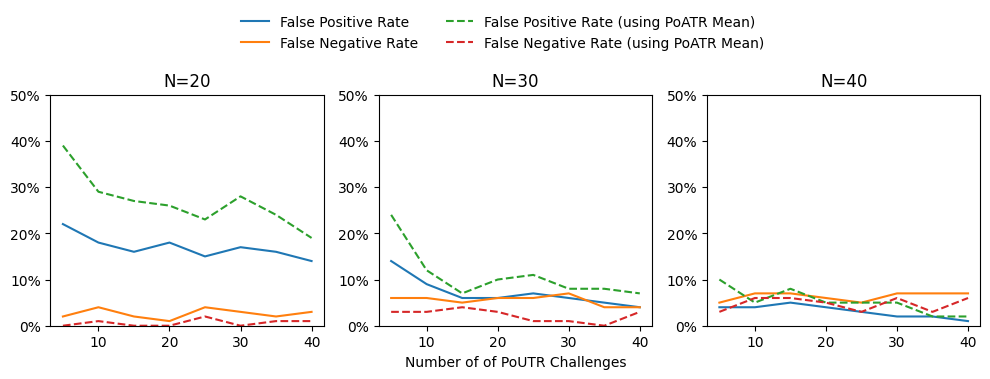

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

for (i, n) in enumerate([20, 30, 40]):
  poutr_accuracy['df2'].detected_1.loc[pd.IndexSlice[False, n]].plot(ax=axs[i], ylim=(0, 50))
  (100 - poutr_accuracy['df2'].detected_1.loc[pd.IndexSlice[True, n]]).plot(ax=axs[i], ylim=(0, 50))
  poutr_accuracy['df2'].detected_2.loc[pd.IndexSlice[False, n]].plot(ax=axs[i], ylim=(0, 50), style="--")
  (100 - poutr_accuracy['df2'].detected_2.loc[pd.IndexSlice[True, n]]).plot(ax=axs[i], ylim=(0, 50), style="--")

  axs[i].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(100))
  axs[i].set_xlabel('')
  axs[i].set_title(f"N={n}")

axs[0].legend([
    'False Positive Rate', 'False Negative Rate',
    'False Positive Rate (using PoATR Mean)', 'False Negative Rate (using PoATR Mean)'
], loc='upper left', bbox_to_anchor=(0.65, 1.4), ncol=2, frameon=False)

axs[1].set_xlabel('Number of of PoUTR Challenges')

plt.savefig('poutr_performance.pdf', dpi=300, bbox_inches = "tight")

# Experiment 6.5: PoUTR FP/FN - No Load

In [56]:
poutr_accuracy_no_load = {
    "path": path + '/2024-06-30_17-18_poutr_accuracy_v2_no_load_'
}

poutr_accuracy_no_load['delay'] = pd.read_table(poutr_accuracy_no_load['path'] + 'delay.txt', header=None) / 1e6
poutr_accuracy_no_load['rtt'] = pd.read_table(poutr_accuracy_no_load['path'] + 'rtt.txt', header=None).mean() / 1e6
poutr_accuracy_no_load['remote'] = pd.read_table(poutr_accuracy_no_load['path'] + 'remote.txt', header=None)
poutr_accuracy_no_load['reps'] = pd.read_table(poutr_accuracy_no_load['path'] + 'reps.txt', header=None)
poutr_accuracy_no_load['n'] = pd.read_table(poutr_accuracy_no_load['path'] + 'n.txt', header=None)

poutr_accuracy_no_load['remote'].replace({0: False, 5: True}, inplace=True)
poutr_accuracy_no_load['df'] = pd.concat([poutr_accuracy_no_load['remote'], poutr_accuracy_no_load['n']], axis = 1)
poutr_accuracy_no_load['df'].columns = ['remote', 'N']
poutr_accuracy_no_load['df'] = poutr_accuracy_no_load['df'].loc[repeat_indices(poutr_accuracy_no_load['reps']), :].reset_index(drop=True)
poutr_accuracy_no_load['df']['delay'] = poutr_accuracy_no_load['delay']

poutr_accuracy_no_load['df']['potr'] = potr(poutr_accuracy_no_load['df'].delay, poutr_accuracy_no_load['rtt'], poutr_accuracy_no_load['df'].N, 0.11)
poutr_accuracy_no_load['df'].set_index(['remote', 'N'], inplace=True)
poutr_accuracy_no_load['df'].drop('delay', axis=1, inplace=True)
poutr_accuracy_no_load['df'].sort_index(inplace=True)

for k in range(5, 41, 5):
  poutr_accuracy_no_load['df'][("k", k)] = poutr_accuracy_no_load['df'].groupby(poutr_accuracy_no_load['df'].index).cumcount() // k

def get_poatr(x):
  poatrs = tmp.loc[pd.IndexSlice[x.index.droplevel([1,2])[0], 250, :], :].potr.values
  i = x.index.droplevel([0,1])[0]
  if i >= len(poatrs):
    return np.nan
  else:
    return poatrs[i]

def std_poatr(x):
  poatr = get_poatr(x)
  if poatr == np.nan:
    return np.nan
  else:
    return np.sqrt(np.square(x - poatr).sum() / (x.count() - 1))

dfs = []
for k in range(5, 41, 5):
  tmp = poutr_accuracy_no_load['df'][['potr', ("k", k)]]
  tmp.set_index([("k", k)], append=True, inplace=True)

  tmp = tmp.groupby(tmp.index).agg([
      get_poatr, # result of corresponding poatr
      "std",
      std_poatr
  ])

  tmp.rename(columns={"potr": k}, inplace=True)
  tmp.columns = tmp.columns.set_levels(['poatr', 'std', 'std_poatr'], level=1)
  tmp.reset_index(inplace=True, names=["level_0", "level_1"])
  tmp.index = pd.MultiIndex.from_tuples(tmp.level_0)
  tmp.index.names = ['remote', 'N', 'i']
  tmp.drop(250, level="N", inplace=True)
  tmp.drop(tmp.loc[pd.IndexSlice[:, :, 100:], :].index, inplace=True)
  tmp.drop("level_0", level=0, axis=1, inplace=True)
  dfs += [tmp]

poutr_accuracy_no_load['df'] = pd.concat(dfs, axis=1).stack(level=0)
poutr_accuracy_no_load['df'].index.names = ['remote', 'N', 'i', 'k']
poutr_accuracy_no_load['df'] = poutr_accuracy_no_load['df'].reorder_levels(['remote', 'N', 'k', 'i'])
poutr_accuracy_no_load['df'].sort_index(inplace=True)

poutr_accuracy_no_load['df']

poatr       std  std_poatr
remote N  k  i                                 
False  10 5  0   17.499233  1.703072   4.107676
             1   18.747533  1.784957   3.176540
             2   17.846644  4.107357   5.707577
             3   18.157200  3.935057   4.370102
             4   18.754713  3.495539   3.841247
...                    ...       ...        ...
True   40 40 95  22.601987  3.347497   3.757817
             96  22.461704  4.432946   4.883694
             97  24.871548  4.338117   4.472731
             98  24.217967  3.091924   3.095589
             99  23.921525  2.596403   2.674020

[6400 rows x 3 columns]

In [57]:
poutr_accuracy_no_load['df']['detected_poatr'] = poutr_accuracy_no_load['df'].poatr > 21.2
poutr_accuracy_no_load['df']['detected_poutr_1'] = poutr_accuracy_no_load['df']['std'] > 6
poutr_accuracy_no_load['df']['detected_poutr_2'] = poutr_accuracy_no_load['df']['std_poatr'] > 6
poutr_accuracy_no_load['df']['detected_1'] = poutr_accuracy_no_load['df'].detected_poatr + poutr_accuracy_no_load['df'].detected_poutr_1
poutr_accuracy_no_load['df']['detected_2'] = poutr_accuracy_no_load['df'].detected_poatr + poutr_accuracy_no_load['df'].detected_poutr_2

print(poutr_accuracy_no_load['df'].detected_poatr.groupby(level=[0,1,2]).sum().loc[pd.IndexSlice[:, 10, 5]])
poutr_accuracy_no_load['df2'] = poutr_accuracy_no_load['df'][['detected_1', 'detected_2']].groupby(level=[0,1,2]).sum().unstack()
poutr_accuracy_no_load['df2']

remote
False     1
True     93
Name: detected_poatr, dtype: int64


detected_1                               detected_2                 \
k                 5   10  15  20  25   30  35   40         5    10   15   20   
remote N                                                                       
False  10          4   4   6   5   6    7   6    7         15    5    6    5   
       20          1   2   3   3   4    5   7    6          2    2    3    3   
       30          3   1   1   1   1    1   1    1          3    2    1    1   
       40          2   2   4   2   2    2   2    2          2    3    4    2   
True   10         99  98  97  99  97  100  99  100        100  100  100  100   
       20         93  94  93  95  95   93  94   94         96   96   96   98   
       30         93  94  96  93  93   93  93   94         95   96   97   93   
       40         93  93  93  93  93   93  93   93         94   94   94   94   

                               
k           25   30   35   40  
remote N                       
False  10    7    9    8    9  
       20    4    5    7    7  
       30    1    2    1    2  
       40    2    2    2    2  
True   10  100  100  100  100  
       20   98   96   97   98  
       30   93   96   96   95  
       40   94   93   93   93

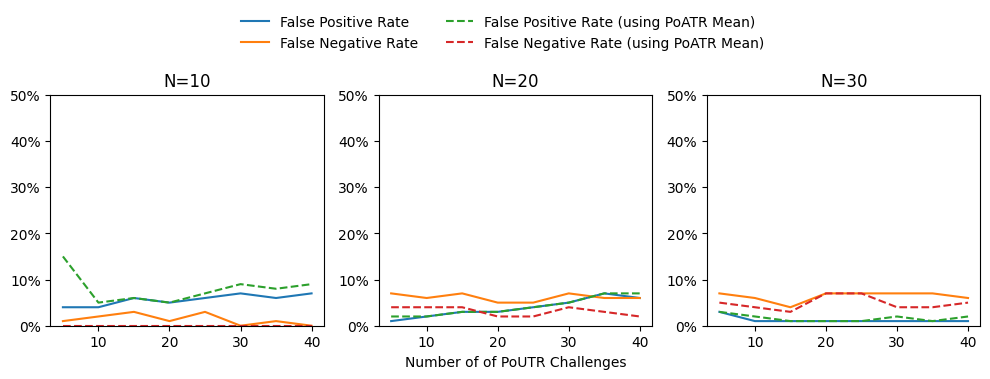

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

for (i, n) in enumerate([10, 20, 30]):
  poutr_accuracy_no_load['df2'].detected_1.loc[pd.IndexSlice[False, n]].plot(ax=axs[i], ylim=(0, 50))
  (100 - poutr_accuracy_no_load['df2'].detected_1.loc[pd.IndexSlice[True, n]]).plot(ax=axs[i], ylim=(0, 50))
  poutr_accuracy_no_load['df2'].detected_2.loc[pd.IndexSlice[False, n]].plot(ax=axs[i], ylim=(0, 50), style="--")
  (100 - poutr_accuracy_no_load['df2'].detected_2.loc[pd.IndexSlice[True, n]]).plot(ax=axs[i], ylim=(0, 50), style="--")

  axs[i].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(100))
  axs[i].set_xlabel('')
  axs[i].set_title(f"N={n}")

axs[0].legend([
    'False Positive Rate', 'False Negative Rate',
    'False Positive Rate (using PoATR Mean)', 'False Negative Rate (using PoATR Mean)'
], loc='upper left', bbox_to_anchor=(0.65, 1.4), ncol=2, frameon=False)

axs[1].set_xlabel('Number of of PoUTR Challenges')

plt.savefig('poutr_performance_no_load.pdf', dpi=300, bbox_inches = "tight")